In [134]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Parameter
import sys
sys.path.append('../')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

('probtorch:', '0.0+ea10cc4', 'torch:', '0.2.0_4', 'cuda:', False)


# Parameters

In [110]:
# model parameters
NUM_PIXELS = 784
NUM_HIDDEN = 400
NUM_Z = 2 # z dimension

# training parameters
NUM_SAMPLES = 5
NUM_BATCH = 200
NUM_EPOCHS = 100
# LABEL_FRACTION = 0.1
LEARNING_RATE = 1e-3
BETA1 = 0.90
EPS = 1e-9
CUDA = torch.cuda.is_available()
#CUDA = False
ALPHAs = [2.0, 5.0, 8.0]
BETAs = [2.0, 5.0, 8.0]
GAMMAs = [2.0, 5.0, 8.0]

# path parameters
MODEL_NAME = 'mnist-avg-encoding-%02ddim' % NUM_Z
DATA_PATH = '../data'
# RESTORE = False

# Encoder Model

In [111]:
class Encoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS,
                       num_hidden=NUM_HIDDEN,
                       num_z=NUM_Z):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(nn.Linear(num_pixels,num_hidden),
                                        nn.ReLU())
        self.z_mean = nn.Linear(num_hidden, num_z)
        self.z_log_std = nn.Linear(num_hidden, num_z)
    
    def forward(self, images, num_samples=1):
        q = probtorch.Trace()
        images = images.expand(num_samples, *images.size())
        hidden = self.enc_hidden(images)
        z_mean = self.z_mean(hidden)
        z_log_std =  torch.exp(self.z_log_std(hidden))
        z = q.normal(z_mean, z_log_std, name='z')
        return q
        

# Decoder Model

In [112]:
def binary_cross_entropy(x_mean, x, EPS=EPS):
    return - (torch.log(x_mean + EPS) * x + 
              torch.log(1 - x_mean + EPS) * (1 - x)).sum(-1)

class Decoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS,
                       num_hidden=NUM_HIDDEN,
                       num_z=NUM_Z):
        super(self.__class__, self).__init__()
        self.dec_hidden = nn.Sequential(nn.Linear(num_z, num_hidden),
                                        nn.ReLU())
        self.x_mean = nn.Sequential(nn.Linear(num_hidden, num_pixels),
                                    nn.Sigmoid())
    
    def forward(self, images, q, num_samples=1):
        p = probtorch.Trace()
        z = p.normal(0.0, 1.0, value=q['z'], name='z')
        hidden = self.dec_hidden(z)
        x_mean = self.x_mean(hidden)
        p.loss(binary_cross_entropy, x_mean, images, name='x')
        return p

# Loss

In [113]:
def elbo(q, p, alpha=1.0, beta=1.0, gamma=1.0):
    return probtorch.objectives.average_encoding.elbo(q, p, sample_dim=0, batch_dim=1,
                                                      alpha=alpha, beta=beta, gamma=gamma)

# Data

In [114]:
from torchvision import datasets, transforms
import os 

if not os.path.isdir(DATA_PATH):
    os.makedirs(DATA_PATH)

train_data = torch.utils.data.DataLoader(
                datasets.MNIST(DATA_PATH, train=True, download=True,
                               transform=transforms.ToTensor()),
                batch_size=NUM_BATCH, shuffle=True) 

# Training 

In [115]:
def init_model():
    enc = Encoder()
    dec = Decoder()
    if CUDA:
        enc.cuda()
        dec.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters())+list(dec.parameters()),
                                  lr=LEARNING_RATE,
                                  betas=(BETA1, 0.999))
    return enc, dec, optimizer  

In [116]:
alpha_models = []
beta_models = []
gamma_models= []

for a in ALPHAs:
    enc, dec, optimizer = init_model()
    alpha_models.append((enc,dec,optimizer))
for b in BETAs:
    enc, dec, optimizer = init_model()
    beta_models.append((enc,dec,optimizer))
for g in GAMMAs:
    enc, dec, optimizer = init_model()
    gamma_models.append((enc,dec,optimizer))

In [117]:
def train(data, enc, dec, optimizer, alpha=1.0, beta=1.0, gamma=1.0):
    epoch_elbo = 0.0
    enc.train()
    dec.train()
    N = 0
    for b, (images, labels) in enumerate(data):
        N += NUM_BATCH
        images = images.view(-1, NUM_PIXELS)
        if CUDA:
            images = images.cuda()
        images = Variable(images)
        optimizer.zero_grad()
        q = enc(images, num_samples=NUM_SAMPLES)
        p = dec(images, q, num_samples=NUM_SAMPLES)
        loss = -elbo(q, p, alpha=alpha, beta=beta, gamma=gamma)
        loss.backward()
        optimizer.step()
        if CUDA:
            loss = loss.cpu()
        epoch_elbo -= loss.data.numpy()[0]
    return epoch_elbo / N

In [118]:
import time

def full_train(enc, dec, optimizer, alpha=1.0, beta=1.0, gamma=1.0):
    for e in range(NUM_EPOCHS):
        train_start = time.time()
        train_elbo = train(train_data, enc, dec, optimizer, alpha=alpha, beta=beta, gamma=gamma)
        train_end = time.time()
        print('[Epoch %d] Train: ELBO %.4e (%ds)' % (
                e, train_elbo, train_end - train_start))

In [119]:
for i, (enc, dec, optimizer) in enumerate(alpha_models):
    full_train(enc, dec, optimizer, alpha=ALPHAs[i])
for i, (enc, dec, optimizer) in enumerate(beta_models):
    full_train(enc, dec, optimizer, beta=BETAs[i])
for i, (enc, dec, optimizer) in enumerate(gamma_models):
    full_train(enc, dec, optimizer, beta=GAMMAs[i]) 

[Epoch 0] Train: ELBO -9.9866e-01 (75s)
[Epoch 1] Train: ELBO -8.6318e-01 (76s)
[Epoch 2] Train: ELBO -8.3529e-01 (75s)
[Epoch 3] Train: ELBO -8.2032e-01 (78s)
[Epoch 4] Train: ELBO -8.0909e-01 (77s)
[Epoch 5] Train: ELBO -8.0069e-01 (75s)
[Epoch 6] Train: ELBO -7.9415e-01 (76s)
[Epoch 7] Train: ELBO -7.8841e-01 (77s)
[Epoch 8] Train: ELBO -7.8387e-01 (79s)
[Epoch 9] Train: ELBO -7.7991e-01 (77s)
[Epoch 10] Train: ELBO -7.7657e-01 (76s)
[Epoch 11] Train: ELBO -7.7398e-01 (77s)
[Epoch 12] Train: ELBO -7.7089e-01 (77s)
[Epoch 13] Train: ELBO -7.6904e-01 (78s)
[Epoch 14] Train: ELBO -7.6695e-01 (81s)
[Epoch 15] Train: ELBO -7.6477e-01 (78s)
[Epoch 16] Train: ELBO -7.6292e-01 (78s)
[Epoch 17] Train: ELBO -7.6156e-01 (76s)
[Epoch 18] Train: ELBO -7.5998e-01 (76s)
[Epoch 19] Train: ELBO -7.5836e-01 (75s)
[Epoch 20] Train: ELBO -7.5714e-01 (78s)
[Epoch 21] Train: ELBO -7.5595e-01 (77s)
[Epoch 22] Train: ELBO -7.5473e-01 (77s)
[Epoch 23] Train: ELBO -7.5367e-01 (76s)
[Epoch 24] Train: ELBO -7.

[Epoch 1] Train: ELBO -8.6833e-01 (69s)
[Epoch 2] Train: ELBO -8.3933e-01 (74s)
[Epoch 3] Train: ELBO -8.2698e-01 (74s)
[Epoch 4] Train: ELBO -8.1861e-01 (75s)
[Epoch 5] Train: ELBO -8.1202e-01 (73s)
[Epoch 6] Train: ELBO -8.0598e-01 (75s)
[Epoch 7] Train: ELBO -8.0092e-01 (75s)
[Epoch 8] Train: ELBO -7.9659e-01 (72s)
[Epoch 9] Train: ELBO -7.9269e-01 (73s)
[Epoch 10] Train: ELBO -7.8911e-01 (74s)
[Epoch 11] Train: ELBO -7.8630e-01 (74s)
[Epoch 12] Train: ELBO -7.8367e-01 (75s)
[Epoch 13] Train: ELBO -7.8164e-01 (74s)
[Epoch 14] Train: ELBO -7.7926e-01 (73s)
[Epoch 15] Train: ELBO -7.7710e-01 (74s)
[Epoch 16] Train: ELBO -7.7547e-01 (74s)
[Epoch 17] Train: ELBO -7.7361e-01 (70s)
[Epoch 18] Train: ELBO -7.7243e-01 (74s)
[Epoch 19] Train: ELBO -7.7108e-01 (74s)
[Epoch 20] Train: ELBO -7.6939e-01 (75s)
[Epoch 21] Train: ELBO -7.6849e-01 (74s)
[Epoch 22] Train: ELBO -7.6739e-01 (75s)
[Epoch 23] Train: ELBO -7.6627e-01 (74s)
[Epoch 24] Train: ELBO -7.6500e-01 (75s)
[Epoch 25] Train: ELBO -7

[Epoch 2] Train: ELBO -8.2383e-01 (76s)
[Epoch 3] Train: ELBO -8.1283e-01 (74s)
[Epoch 4] Train: ELBO -8.0443e-01 (73s)
[Epoch 5] Train: ELBO -7.9730e-01 (75s)
[Epoch 6] Train: ELBO -7.9133e-01 (75s)
[Epoch 7] Train: ELBO -7.8585e-01 (74s)
[Epoch 8] Train: ELBO -7.8146e-01 (74s)
[Epoch 9] Train: ELBO -7.7745e-01 (73s)
[Epoch 10] Train: ELBO -7.7407e-01 (73s)
[Epoch 11] Train: ELBO -7.7071e-01 (74s)
[Epoch 12] Train: ELBO -7.6839e-01 (76s)
[Epoch 13] Train: ELBO -7.6596e-01 (75s)
[Epoch 14] Train: ELBO -7.6357e-01 (76s)
[Epoch 15] Train: ELBO -7.6183e-01 (74s)
[Epoch 16] Train: ELBO -7.6024e-01 (73s)
[Epoch 17] Train: ELBO -7.5823e-01 (73s)
[Epoch 18] Train: ELBO -7.5685e-01 (76s)
[Epoch 19] Train: ELBO -7.5518e-01 (73s)
[Epoch 20] Train: ELBO -7.5411e-01 (74s)
[Epoch 21] Train: ELBO -7.5251e-01 (71s)
[Epoch 22] Train: ELBO -7.5166e-01 (75s)
[Epoch 23] Train: ELBO -7.5060e-01 (72s)
[Epoch 24] Train: ELBO -7.4905e-01 (75s)
[Epoch 25] Train: ELBO -7.4805e-01 (74s)
[Epoch 26] Train: ELBO -

[Epoch 3] Train: ELBO -8.1295e-01 (75s)
[Epoch 4] Train: ELBO -8.0464e-01 (75s)
[Epoch 5] Train: ELBO -7.9761e-01 (75s)
[Epoch 6] Train: ELBO -7.9125e-01 (73s)
[Epoch 7] Train: ELBO -7.8592e-01 (74s)
[Epoch 8] Train: ELBO -7.8124e-01 (74s)
[Epoch 9] Train: ELBO -7.7691e-01 (73s)
[Epoch 10] Train: ELBO -7.7377e-01 (84s)
[Epoch 11] Train: ELBO -7.7037e-01 (79s)
[Epoch 12] Train: ELBO -7.6768e-01 (81s)
[Epoch 13] Train: ELBO -7.6503e-01 (78s)
[Epoch 14] Train: ELBO -7.6295e-01 (81s)
[Epoch 15] Train: ELBO -7.6098e-01 (83s)
[Epoch 16] Train: ELBO -7.5919e-01 (79s)
[Epoch 17] Train: ELBO -7.5753e-01 (81s)
[Epoch 18] Train: ELBO -7.5584e-01 (79s)
[Epoch 19] Train: ELBO -7.5441e-01 (82s)
[Epoch 20] Train: ELBO -7.5293e-01 (78s)
[Epoch 21] Train: ELBO -7.5144e-01 (81s)
[Epoch 22] Train: ELBO -7.5042e-01 (82s)
[Epoch 23] Train: ELBO -7.4910e-01 (82s)
[Epoch 24] Train: ELBO -7.4814e-01 (80s)
[Epoch 25] Train: ELBO -7.4672e-01 (79s)
[Epoch 26] Train: ELBO -7.4561e-01 (78s)
[Epoch 27] Train: ELBO 

[Epoch 4] Train: ELBO -8.0707e-01 (77s)
[Epoch 5] Train: ELBO -7.9898e-01 (77s)
[Epoch 6] Train: ELBO -7.9239e-01 (79s)
[Epoch 7] Train: ELBO -7.8651e-01 (80s)
[Epoch 8] Train: ELBO -7.8132e-01 (81s)
[Epoch 9] Train: ELBO -7.7684e-01 (80s)
[Epoch 10] Train: ELBO -7.7314e-01 (81s)
[Epoch 11] Train: ELBO -7.6961e-01 (83s)
[Epoch 12] Train: ELBO -7.6671e-01 (86s)
[Epoch 13] Train: ELBO -7.6426e-01 (81s)
[Epoch 14] Train: ELBO -7.6192e-01 (79s)
[Epoch 15] Train: ELBO -7.5967e-01 (77s)
[Epoch 16] Train: ELBO -7.5778e-01 (78s)
[Epoch 17] Train: ELBO -7.5603e-01 (80s)
[Epoch 18] Train: ELBO -7.5431e-01 (81s)
[Epoch 19] Train: ELBO -7.5272e-01 (93s)
[Epoch 20] Train: ELBO -7.5136e-01 (88s)
[Epoch 21] Train: ELBO -7.4989e-01 (79s)
[Epoch 22] Train: ELBO -7.4852e-01 (79s)
[Epoch 23] Train: ELBO -7.4736e-01 (77s)
[Epoch 24] Train: ELBO -7.4634e-01 (92s)
[Epoch 25] Train: ELBO -7.4512e-01 (96s)
[Epoch 26] Train: ELBO -7.4390e-01 (136s)
[Epoch 27] Train: ELBO -7.4310e-01 (140s)
[Epoch 28] Train: EL

In [122]:
# save models
for i, a in enumerate(ALPHAs):
    enc_a = alpha_models[i][0]
    torch.save(enc_a, "VAEa="+str(a)+".pt")
for i, b in enumerate(BETAs):
    enc_b = beta_models[i][0]
    torch.save(enc_b, "VAEb="+str(b)+".pt")
for i, g in enumerate(GAMMAs):
    enc_g = gamma_models[i][0]
    torch.save(enc_g, "VAEg="+str(g)+".pt")

/home/babak/miniconda2/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Visualize Embeddings

In [123]:
# load models:
Enc_a2 = torch.load('VAEa=2.0.pt')
Enc_a5 = torch.load('VAEa=5.0.pt')
Enc_a8 = torch.load('VAEa=8.0.pt')
Enc_b2 = torch.load('VAEb=2.0.pt')
Enc_b5 = torch.load('VAEb=5.0.pt')
Enc_b8 = torch.load('VAEb=8.0.pt')
Enc_g2 = torch.load('VAEg=2.0.pt')
Enc_g5 = torch.load('VAEg=5.0.pt')
Enc_g8 = torch.load('VAEg=8.0.pt')

In [159]:
import pandas as pd
def form_dataframe(dataset, encoder, name, z_dim):
    """
    Return a pandas table with columns = [Digit, z1, z2, ..., zD, std1, std2,
    ... stdD] (For MNIST)
    """

    Data = []
    count = 0
    first_row = ['','Digit']
    for dim in range(1,z_dim+1):
        first_row.append("z" + str(dim))
    for dim in range(1,z_dim+1):
        first_row.append("std" + str(dim))
    Data.append(first_row)
    for i, (images, labels) in enumerate(dataset):
        images = Variable(images.view(-1,NUM_PIXELS))
        q = encoder(images)
        z_mu = q[name].dist.mean[0,:]
        z_sigma = q[name].dist.sigma[0,:]
        for j in range(NUM_BATCH):
            row = []
            row.append(count)
            count += 1
            row.append(labels[j])
            for dim in range(z_dim):
                row.append(z_mu.data[j,:][dim])
            for dim in range(z_dim):
                row.append(z_sigma.data[j,:][dim])
            Data.append(row)

    data = np.array(Data)
    return pd.DataFrame(data=data[1:,1:], index=data[1:,0], columns=data[0,1:])

In [170]:
frame_a2 = form_dataframe(train_data, Enc_a2, 'z', 2).apply(pd.to_numeric, errors='coerce')
frame_a5 = form_dataframe(train_data, Enc_a5, 'z', 2).apply(pd.to_numeric, errors='coerce')
frame_a8 = form_dataframe(train_data, Enc_a8, 'z', 2).apply(pd.to_numeric, errors='coerce')
frame_b2 = form_dataframe(train_data, Enc_b2, 'z', 2).apply(pd.to_numeric, errors='coerce')
frame_b5 = form_dataframe(train_data, Enc_b5, 'z', 2).apply(pd.to_numeric, errors='coerce')
frame_b8 = form_dataframe(train_data, Enc_b8, 'z', 2).apply(pd.to_numeric, errors='coerce')
frame_g2 = form_dataframe(train_data, Enc_g2, 'z', 2).apply(pd.to_numeric, errors='coerce')
frame_g5 = form_dataframe(train_data, Enc_g5, 'z', 2).apply(pd.to_numeric, errors='coerce')
frame_g8 = form_dataframe(train_data, Enc_g8, 'z', 2).apply(pd.to_numeric, errors='coerce')

In [207]:
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

z_string = ["z1", "z2"]

def scatter_plot(dataframe, ax, title):
    for digit in range(10):
        class_points = dataframe[dataframe['Digit'] == digit]
        zs = class_points[z_string].as_matrix()
        ax.scatter(zs[:,0], zs[:,1], label=str(digit))
    ax.set_xlabel(r'$\boldsymbol{z_{1}}$',fontsize=10)
    ax.set_ylabel(r'$\boldsymbol{z_{2}}$',fontsize=10)
    ax.set_title(title,fontsize=20)
    ax.legend(title='Digit',loc=1)
    return ax

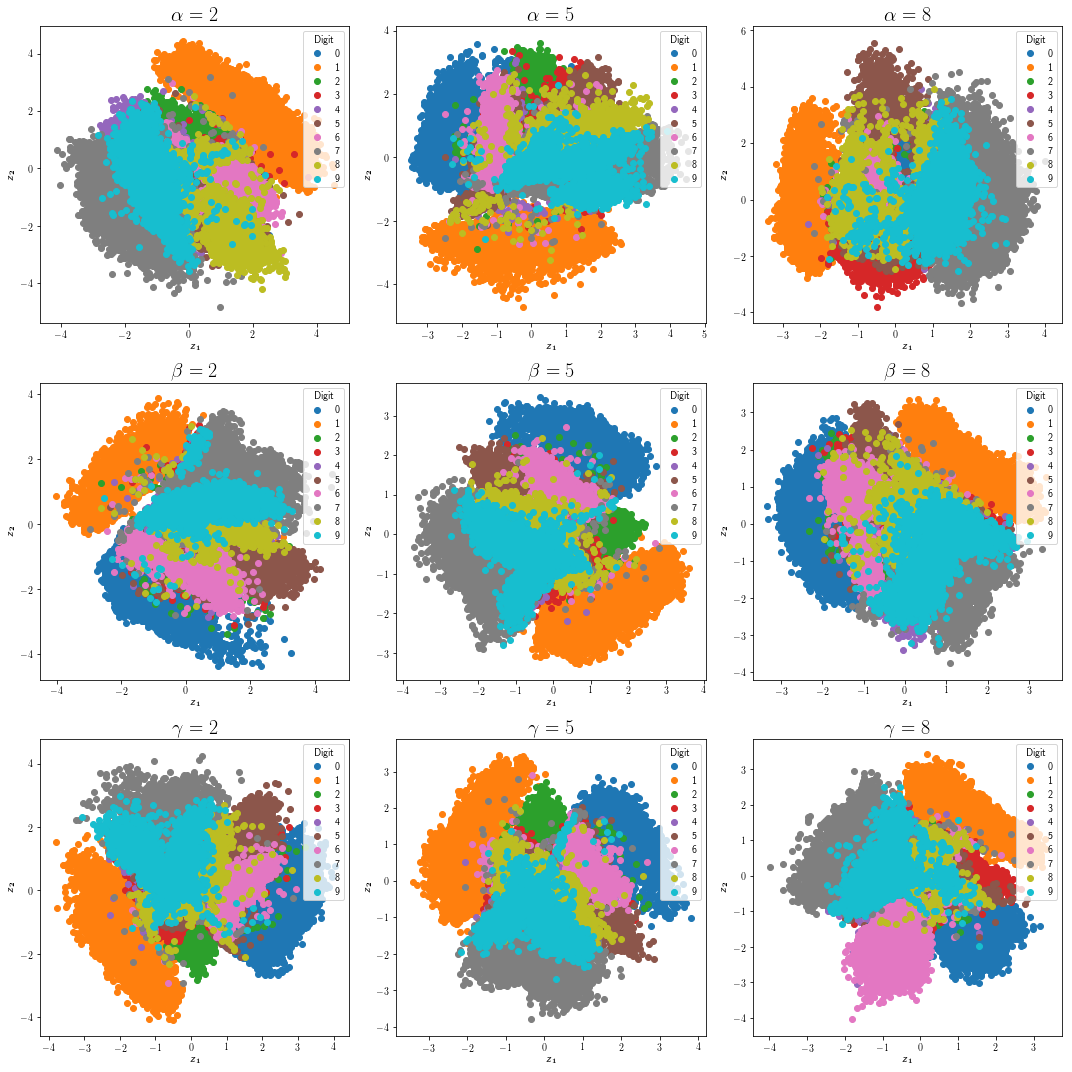

In [208]:
# Sorry about the mess!
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
scatter_plot(frame_a2, ax1, title=r"$\alpha = 2$")
scatter_plot(frame_a5, ax2, title=r"$\alpha = 5$")
scatter_plot(frame_a8, ax3, title=r"$\alpha = 8$")
scatter_plot(frame_b2, ax4, title=r"$\beta = 2$")
scatter_plot(frame_b5, ax5, title=r"$\beta = 5$")
scatter_plot(frame_b8, ax6, title=r"$\beta = 8$")
scatter_plot(frame_g2, ax7, title=r"$\gamma = 2$")
scatter_plot(frame_g5, ax8, title=r"$\gamma = 5$")
scatter_plot(frame_g8, ax9, title=r"$\gamma = 8$")
plt.tight_layout()
plt.show()